In [37]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier
import h5py
import mat4py
import matplotlib.pyplot as plt
import math
from sklearn.feature_selection import RFE
from sklearn.model_selection import RandomizedSearchCV

# Ignoring warning messages in output
import warnings
warnings.filterwarnings('ignore')

In [114]:
# Function for accessing the raw data from the .eye files

def eye2array(file, debug=False):
    #Converts the .eye file to numpy array.
    #Open file and split into trials.
    with open(file, 'r') as f:
        string = f.read()
    strings = string.split('[Eye Sample Data (')[1:]

    #Remove metadata from each trial.
    for i in range(len(strings)):
        #Print trial number if debug is on.
        if debug:
            num_end = strings[i].find('of 101)]')-1
            num = int(strings[i][:num_end])
            print(num)

        #Split at the exact place. And seperate x,y,z coordinates.
        strings[i] = strings[i].split('.iml')
        strings[i] = strings[i][1][5:]
        strings[i] = strings[i].split('\n[Task Data]\n')[0]
        strings[i] = strings[i].split('\n')

        #Convert each reading into numpy array
        for x in range(len(strings[i])):        
            strings[i][x] = np.array(strings[i][x].split(), dtype=float)
        strings[i] = np.array(strings[i])
        
    return np.array(strings)
            
def punish_all_eyes(folder, debug=False, verbose=False):
    #Saves all files as numpy arrays in a dictionary, participant ID as key.
    all_eyes = {}
    files = os.listdir(folder)
    files = [x for x in files if x[0] != '.']

    #Loop through files in folder and convert
    for file in files:
        if verbose:
            print(f'Converting {file}...')
        all_eyes[file[:-4]] = eye2array(os.path.join(folder, file), debug=debug)
        
        if debug:
            print(len(all_eyes[file[:-4]]), 'recordings.')
            

    return all_eyes

In [134]:
# Get participant data from file and remove nan values
os.chdir("C:\\Users\lasse\Desktop\Cognitive Science 3\Report\Datasets\Doves")
particip_data_doves = pd.read_excel('DOVES_Observer_Details.xls', header=2)
particip_data_doves.dropna(subset = ['Age'], inplace=True)

# Get list of filenames
os.chdir("C:\\Users\lasse\Desktop\Cognitive Science 3\Report\Datasets\Doves\Fixations")
file_names = os.listdir()
del file_names[0]

# Load fixation data from files
data_doves = []
for f in file_names:
    #print(f)
    data_doves.append(mat4py.loadmat(f))

# Load raw data from files
os.chdir("C:\\Users\lasse\Desktop\Cognitive Science 3\Report\Datasets\Doves")
rawdata_doves = punish_all_eyes('RawData', debug=False, verbose=False)

# Generate a list of the order of participants. Used for selecting correct data from raw data dictionary
subject_ordered_list = data_doves[0]['subj_names_list']
for num, sub in enumerate(subject_ordered_list):
    split = sub.split('.', 1)
    subject_ordered_list[num] = split[0]

### Participant Data:

In [21]:
# Print statistics of participant data
print(f"DOVES Max age: {particip_data_doves.Age.max()}, min age: {particip_data_doves.Age.min()}, mean age: {particip_data_doves.Age.mean()}")
print(f"DOVES Number of females: {particip_data_doves.Gender.value_counts()[0]}, number of males: {particip_data_doves.Gender.value_counts()[1]}")

DOVES Max age: 45.0, min age: 16.0, mean age: 26.586206896551722
DOVES Number of females: 18, number of males: 11


### Feature Selection

In [22]:
# Generate lists of ages and gender from dataframe
gender_list = particip_data_doves.Gender.tolist()
age_list = particip_data_doves.Age.tolist()

In [23]:
# Utility for getting distance bewteen two points
def get_dist(p1, p2):
    dist = math.sqrt(((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2))
    return dist

In [25]:
# DOVES feature extraction
# data_doves['fix_data'] is all data for 1(!) image, with each index being data for each participant.

# Features to extract
mean_fixdur = []
sd_fixdur = []
max_fixdur = []
min_fixdur = []

n_fix = []

mean_saccade_len = []
sd_saccade_len = []
max_saccade_len = []
min_saccade_len = []
total_saccade_len = []

fixations_X = []
fixations_Y = []

# Loop through fixation data, appending data to the designated lists
for img_entry in data_doves:
    for entry in img_entry['fix_data']:
        mean_fixdur.append(np.mean(entry[2]))
        sd_fixdur.append(np.std(entry[2]))
        max_fixdur.append(max(entry[2]))
        min_fixdur.append(min(entry[2]))
        
        n_fix.append(len(entry[0]))
        
        xfix = entry[0]
        yfix = entry[1]
        if len(entry[0]) < 22:
            fixations_X.append(xfix.extend([0]*(22-len(xfix))))
            fixations_Y.append(yfix.extend([0]*(22-len(yfix))))
        else:
            fixations_X.append(xfix)
            fixations_Y.append(yfix)
        
        saccade_dists = []
        for i in range(len(entry[0])-1):
            p1 = [entry[0][i], entry[1][i]]
            p2 = [entry[0][i+1], entry[1][i+1]]
            saccade_dists.append(get_dist(p1, p2))
        if len(saccade_dists) > 0:
            mean_saccade_len.append(np.mean(saccade_dists))
            sd_saccade_len.append(np.std(saccade_dists))
            max_saccade_len.append(max(saccade_dists))
            min_saccade_len.append(min(saccade_dists))
            total_saccade_len.append(sum(saccade_dists))
        else:
            mean_saccade_len.append(0)
            sd_saccade_len.append(0)
            max_saccade_len.append(0)
            min_saccade_len.append(0)
            total_saccade_len.append(0)

# Create a feature vector and append it to X
X = []
for i in range(len(mean_fixdur)):
    X.append([
        mean_fixdur[i], sd_fixdur[i], max_fixdur[i],
        min_fixdur[i], n_fix[i], mean_saccade_len[i],
        sd_saccade_len[i], max_saccade_len[i], min_saccade_len[i],
        total_saccade_len[i]
    ])
    X[i].extend(fixations_X[i])
    X[i].extend(fixations_Y[i])

In [81]:
# Y definition

# Gender Y
Y = []

for img_entry in data_doves:
    for i in range(len(img_entry['fix_data'])):
        Y.append(gender_list[i])
        
for i in range(len(Y)):
    if Y[i] == 'M':
        Y[i] = 0
    elif Y[i] == 'F':
        Y[i] = 1
        

# Age Y
alt_Y = []

for img_entry in data_doves:
    for i in range(len(img_entry['fix_data'])):
        alt_Y.append(age_list[i])
        
for i in range(len(alt_Y)):
    if alt_Y[i] >= 27:
        alt_Y[i] = 0
    elif alt_Y[i] < 27:
        alt_Y[i] = 1

In [82]:
# Remove nan's from the X values and replace them with 0
for i in range(len(X)):
    for j in range(len(X[i])):
        if math.isnan(X[i][j]):
            X[i][j] = 0

### Classification

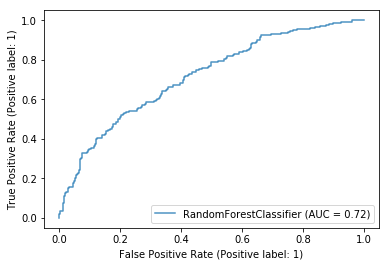

In [85]:
# Random Forest

X = np.array(X)
y = np.array(Y)

model = RandomForestClassifier(
    n_estimators=1000, criterion='entropy', min_samples_split=5,
    min_samples_leaf=1, random_state=42, max_features='sqrt'
)

acc_score = []
f1 = []
recall = []
precision = []

k = 5
kf = KFold(n_splits=k, shuffle=False)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
    
    acc_score.append(accuracy_score(y_test, pred_values))
    f1.append(f1_score(y_test, pred_values))
    precision.append(precision_score(y_test, pred_values))
    recall.append(recall_score(y_test, pred_values))

ax = plt.gca()
rfc_disp = plot_roc_curve(model, X_test, y_test, ax=ax, alpha=0.8)
    
rfc_avg_acc_score = sum(acc_score)/k
rfc_avg_f1_score = sum(f1)/k
rfc_avg_recall = sum(recall)/k
rfc_avg_precision = sum(precision)/k


Random forest classifier results:
Avg. acc. = 0.6995513549779762
Avg. F1 = 0.4680671942915022
Avg. recall = 0.35038008402610166
Avg. precision = 0.7153726737522417

Dummy classifier results:
Avg. acc. = 0.6206878445786296
Avg. F1 = 0.0
Avg. recall = 0.0
Avg. precision = 0.0



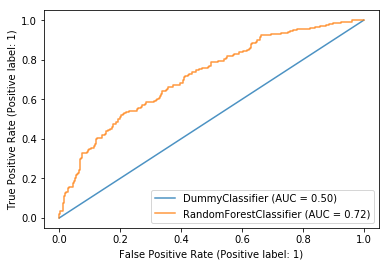

In [86]:
# Dummy Classifier

X = np.array(X)
y = np.array(Y)

model = DummyClassifier(strategy="most_frequent")

acc_score = []
f1 = []
recall = []
precision = []

k = 5
kf = KFold(n_splits=k, shuffle=False)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
    
    acc_score.append(accuracy_score(y_test, pred_values))
    f1.append(f1_score(y_test, pred_values))
    precision.append(precision_score(y_test, pred_values))
    recall.append(recall_score(y_test, pred_values))

ax = plt.gca()
d_disp = plot_roc_curve(model, X_test, y_test, ax=ax, alpha=0.8)
rfc_disp.plot(ax=ax, alpha=0.8)
    
d_avg_acc_score = sum(acc_score)/k
d_avg_f1_score = sum(f1)/k
d_avg_recall = sum(recall)/k
d_avg_precision = sum(precision)/k

print(f"""
Random forest classifier results:
Avg. acc. = {rfc_avg_acc_score}
Avg. F1 = {rfc_avg_f1_score}
Avg. recall = {rfc_avg_recall}
Avg. precision = {rfc_avg_precision}

Dummy classifier results:
Avg. acc. = {d_avg_acc_score}
Avg. F1 = {d_avg_f1_score}
Avg. recall = {d_avg_recall}
Avg. precision = {d_avg_precision}
""")
